In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Percorso al dataset (modifica con il tuo)
dataset_path = './CUB_200_2011/CUB_200_2011'

# Vediamo cosa c'è dentro
print("Contenuto della cartella:")
for item in os.listdir(dataset_path):
    print(f"  - {item}")

Contenuto della cartella:
  - bounding_boxes.txt
  - train_test_split.txt
  - README
  - attributes
  - images
  - image_class_labels.txt
  - classes.txt
  - parts
  - images.txt


In [2]:
# Carica i file di testo
images_df = pd.read_csv(
    os.path.join(dataset_path, 'images.txt'), 
    sep=' ', 
    names=['img_id', 'filepath']
)

labels_df = pd.read_csv(
    os.path.join(dataset_path, 'image_class_labels.txt'),
    sep=' ',
    names=['img_id', 'class_id']
)

train_test_df = pd.read_csv(
    os.path.join(dataset_path, 'train_test_split.txt'),
    sep=' ',
    names=['img_id', 'is_train']
)

# Carica le annotazioni delle PARTI - cruciale!
parts_df = pd.read_csv(
    os.path.join(dataset_path, 'parts/part_locs.txt'),
    sep=' ',
    names=['img_id', 'part_id', 'x', 'y', 'visible']
)

# Merge tutto insieme
data = images_df.merge(labels_df, on='img_id')
data = data.merge(train_test_df, on='img_id')

print(f"Numero totale di immagini: {len(data)}")
print(f"Numero immagini train: {data['is_train'].sum()}")
print(f"Numero immagini test: {(~data['is_train'].astype(bool)).sum()}")
print(f"\nPrime righe:")
print(data.head())

Numero totale di immagini: 11788
Numero immagini train: 5994
Numero immagini test: 5794

Prime righe:
   img_id                                           filepath  class_id  \
0       1  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
1       2  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
2       3  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
3       4  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
4       5  001.Black_footed_Albatross/Black_Footed_Albatr...         1   

   is_train  
0         0  
1         1  
2         0  
3         1  
4         1  


KeyError: 'class_id'

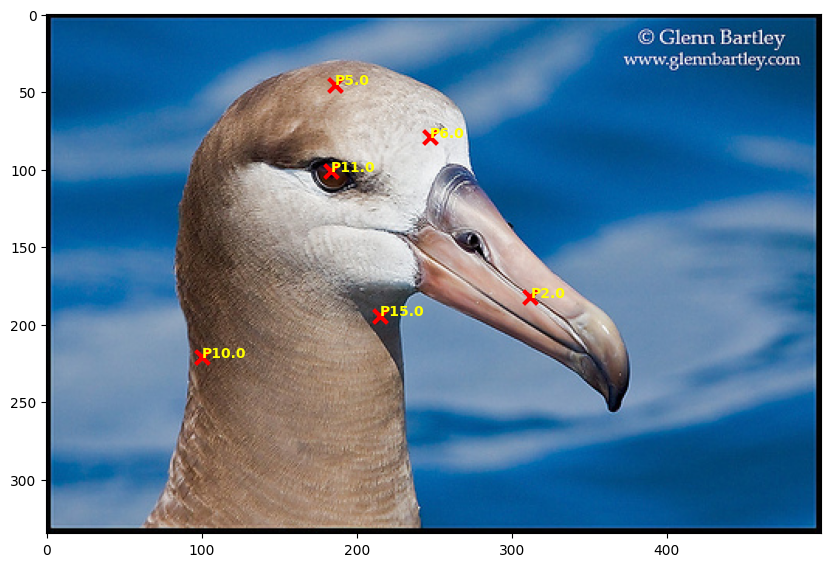

In [3]:
def visualize_image_with_parts(img_id, dataset_path, parts_df):
    """Visualizza un'immagine con le parti annotate"""
    
    # Carica l'immagine
    img_info = images_df[images_df['img_id'] == img_id].iloc[0]
    img_path = os.path.join(dataset_path, 'images', img_info['filepath'])
    img = Image.open(img_path)
    
    # Ottieni le parti per questa immagine
    img_parts = parts_df[parts_df['img_id'] == img_id]
    
    # Visualizza
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    
    # Plotta le parti visibili
    visible_parts = img_parts[img_parts['visible'] == 1]
    plt.scatter(visible_parts['x'], visible_parts['y'], 
                c='red', s=100, marker='x', linewidths=3)
    
    # Aggiungi etichette
    for idx, row in visible_parts.iterrows():
        plt.annotate(f"P{row['part_id']}", 
                    (row['x'], row['y']), 
                    color='yellow', fontsize=10, fontweight='bold')
    
    plt.title(f"Image ID: {img_id} | Class: {img_info['class_id']}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Parti visibili: {len(visible_parts)}/15")
    print(f"Parti annotate:\n{visible_parts[['part_id', 'x', 'y']]}")

# Prova con la prima immagine del test set
test_imgs = data[data['is_train'] == 0]
first_test_id = test_imgs.iloc[0]['img_id']
visualize_image_with_parts(first_test_id, dataset_path, parts_df)

In [4]:
# Mappa delle parti (da documentazione CUB200)
PART_NAMES = {
    1: 'back',
    2: 'beak',
    3: 'belly',
    4: 'breast',
    5: 'crown',
    6: 'forehead',
    7: 'left_eye',
    8: 'left_leg',
    9: 'left_wing',
    10: 'nape',
    11: 'right_eye',
    12: 'right_leg',
    13: 'right_wing',
    14: 'tail',
    15: 'throat'
}

# Statistiche sulle parti visibili
part_visibility = parts_df.groupby('part_id')['visible'].mean()
print("Percentuale di visibilità per ogni parte:")
for part_id, visibility in part_visibility.items():
    print(f"  {PART_NAMES[part_id]:15s}: {visibility*100:.1f}%")

Percentuale di visibilità per ogni parte:
  back           : 76.9%
  beak           : 99.6%
  belly          : 87.8%
  breast         : 93.0%
  crown          : 98.2%
  forehead       : 98.4%
  left_eye       : 49.7%
  left_leg       : 72.0%
  left_wing      : 55.8%
  nape           : 96.0%
  right_eye      : 51.6%
  right_leg      : 72.3%
  right_wing     : 56.6%
  tail           : 93.0%
  throat         : 98.7%


In [6]:
# Seleziona 50 immagini di test con molte parti visibili
def select_good_samples(parts_df, data, n_samples=50):
    """Seleziona immagini con almeno 10 parti visibili"""
    
    # Conta parti visibili per immagine
    visible_counts = parts_df[parts_df['visible'] == 1].groupby('img_id').size()
    
    # Filtra solo immagini di test con molte parti
    test_ids = data[data['is_train'] == 0]['img_id']
    good_test_ids = visible_counts[visible_counts >= 10].index
    good_test_ids = [id for id in good_test_ids if id in test_ids.values]
    
    # Prendi i primi n_samples
    selected_ids = good_test_ids[:n_samples]
    
    return selected_ids

working_set_ids = select_good_samples(parts_df, data, n_samples=50)
print(f"Selezionate {len(working_set_ids)} immagini per il working set")

# Salva per dopo
np.save('working_set_ids.npy', working_set_ids)


Selezionate 50 immagini per il working set


In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Test del dataset loader
from src.data_utils import CUBDataset, get_part_annotations

# Definisci trasformazioni base
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Crea dataset
working_set_ids = np.load('working_set_ids.npy')
dataset = CUBDataset(dataset_path, image_ids=working_set_ids, transform=transform)

print(f"Dataset creato: {len(dataset)} immagini")

# Testa un sample
sample = dataset[0]
print(f"Shape immagine: {sample['image'].shape}")
print(f"Label: {sample['label']}")
print(f"ID: {sample['img_id']}")

# Ottieni parti
parts = get_part_annotations(dataset_path, sample['img_id'])
print(f"Parti visibili: {len(parts)}")

Dataset creato: 50 immagini
Shape immagine: torch.Size([3, 224, 224])
Label: 0
ID: 3
Parti visibili: 11


In [8]:
# Test rapido
from src.model import get_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Crea modello
model = get_model(pretrained=True, architecture='resnet50', device=device)
model.eval()

# Test forward pass
sample = dataset[0]
input_tensor = sample['image'].unsqueeze(0).to(device)  # batch size 1

with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    
print(f"Output shape: {output.shape}")  # [1, 200]
print(f"Predicted class: {predicted_class}")
print(f"True class: {sample['label']}")

Using device: cpu


/home/samuele/miniconda3/envs/NLP/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samuele/miniconda3/envs/NLP/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([1, 200])
Predicted class: 199
True class: 0


In [9]:
from torch.utils.data import DataLoader
from src.train import train_model
from src.data_utils import CUBDataset
from torchvision import transforms

# Prepara transform con data augmentation per training
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Carica train/val split completo
train_ids = data[data['is_train'] == 1]['img_id'].values
val_ids = data[data['is_train'] == 0]['img_id'].values[:1000]  # subset validation

train_dataset = CUBDataset(dataset_path, image_ids=train_ids, transform=train_transform)
val_dataset = CUBDataset(dataset_path, image_ids=val_ids, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Train (OPZIONALE - solo se vuoi migliorare il modello)
# model = train_model(model, train_loader, val_loader, num_epochs=5, device=device)

In [10]:
# Test tutti gli explainer
import tqdm as notebook_tqdm
from src.explainers import (
    IntegratedGradientsExplainer,
    InputGradientsExplainer,
    GradientShapExplainer,
    LimeExplainer
)

# Prendi un'immagine di test
dataset = CUBDataset(dataset_path, image_ids=working_set_ids, transform=transform)
sample = dataset[0]
input_tensor = sample['image'].unsqueeze(0)
true_label = sample['label']
img_id = sample['img_id']

print(f"Testing explainers on image {img_id}, true label: {true_label}")

# Inizializza explainer
explainers = {
    'Integrated Gradients': IntegratedGradientsExplainer(model, device),
    'Input Gradients': InputGradientsExplainer(model, device),
    'GradientSHAP': GradientShapExplainer(model, device),
    'LIME': LimeExplainer(model, device)
}

# Genera spiegazioni
attributions = {}
for name, explainer in explainers.items():
    print(f"Running {name}...")
    attr_map, pred_class = explainer.explain(input_tensor, target_class=true_label)
    attributions[name] = attr_map
    print(f"  ✓ Done. Predicted class: {pred_class}")

print("\nAll explainers completed!")

/home/samuele/miniconda3/envs/NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing explainers on image 3, true label: 0
Running Integrated Gradients...
  ✓ Done. Predicted class: 0
Running Input Gradients...
  ✓ Done. Predicted class: 0
Running GradientSHAP...
  ✓ Done. Predicted class: 0
Running LIME...


/home/samuele/miniconda3/envs/NLP/lib/python3.12/site-packages/captum/attr/_core/lime.py:1141: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  warnings.warn(


  ✓ Done. Predicted class: 0

All explainers completed!


Saved to results/figures/attributions_3.png


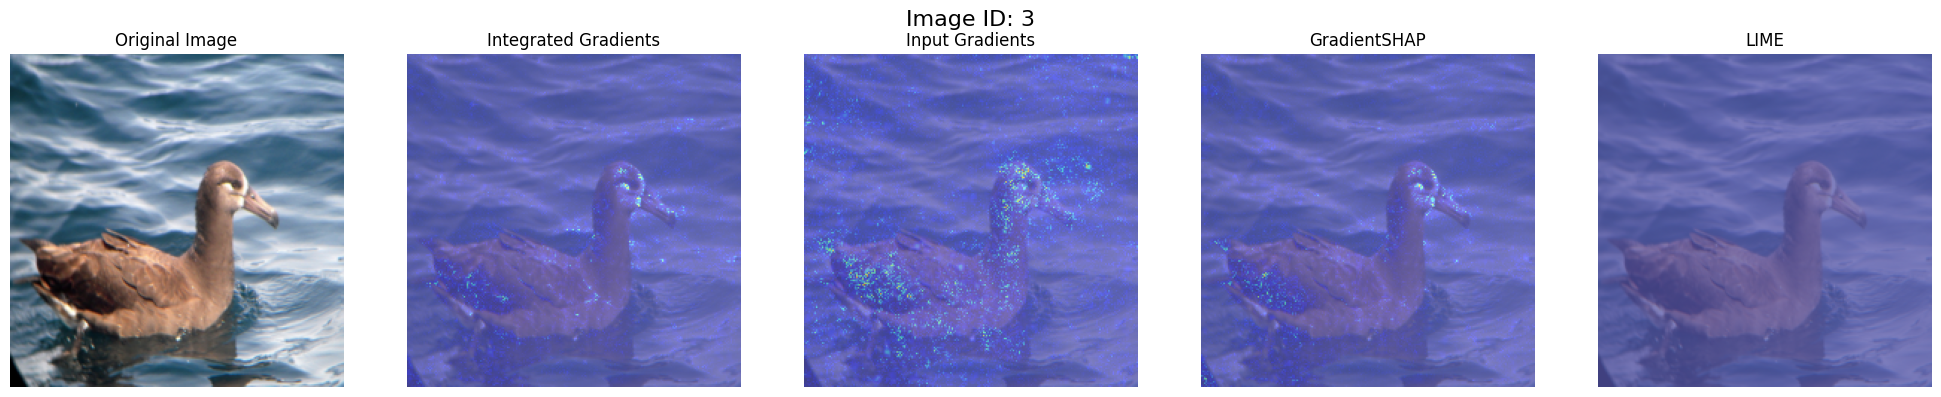

In [11]:
import matplotlib.pyplot as plt

def visualize_attributions(image, attributions_dict, img_id, save_path=None):
    """Visualizza l'immagine originale e tutte le attribution maps"""
    
    n_methods = len(attributions_dict)
    fig, axes = plt.subplots(1, n_methods + 1, figsize=(4 * (n_methods + 1), 4))
    
    # Denormalizza immagine per visualizzazione
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = image.cpu().numpy().transpose(1, 2, 0)
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    # Immagine originale
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Attribution maps
    for idx, (name, attr_map) in enumerate(attributions_dict.items()):
        axes[idx + 1].imshow(img_np, alpha=0.5)
        axes[idx + 1].imshow(attr_map, cmap='jet', alpha=0.5)
        axes[idx + 1].set_title(name)
        axes[idx + 1].axis('off')
    
    plt.suptitle(f'Image ID: {img_id}', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()

# Visualizza
visualize_attributions(
    sample['image'], 
    attributions, 
    img_id,
    save_path=f'results/figures/attributions_{img_id}.png'
)